<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Initialize

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

['main.ipynb',
 'givemetestimg.py',
 'network.py',
 'solve.py',
 'datasets',
 '__pycache__',
 '.ipynb_checkpoints']

In [3]:
import numpy as np
import torch
import torch.nn as nn
from collections import OrderedDict
import imageio
import matplotlib.pyplot as plt
import argparse, os, sys
import cv2
from PIL import Image
import torchvision.models as models

In [4]:
dataset_afw_path="/content/drive/My Drive/Face Alignment DRF/datasets/afw"

Dataset: 300W https://ibug.doc.ic.ac.uk/resources/300-W/

# 2. Data preparation

In [5]:
# https://github.com/musyoku/face-alignment-at-3000fps/blob/master/run/train.py

def load_annotations(directory):
	annotations = {}
	fs = os.listdir(directory)
	for filename in fs:
		if filename.endswith(".pts"):
			with open(os.path.join(directory, filename), "r") as f:
				annotation = f.read().strip().split("\n")
				#assert len(annotation) == 72
				landmarks = []
				for location_str in annotation[3:-1]:
					location = location_str.split(" ")
					landmarks.append((float(location[0]), float(location[1])))
				annotations[filename.replace(".pts", "")] = landmarks
	return annotations

In [6]:
#annotations_afw = load_annotations(dataset_afw_path)

# 3. Test picture

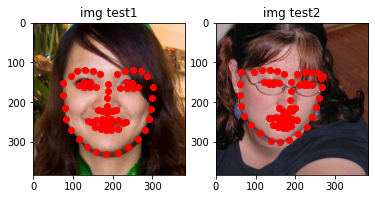

In [8]:
from givemetestimg import *

img_test, label = testimgbatch(dataset_afw_path)
labelx, labely, labelx2, labely2 = label

testimg1 = img_test[0,:,:,:].permute(1,2,0).numpy().astype(np.uint8)
testimg2 = img_test[1,:,:,:].permute(1,2,0).numpy().astype(np.uint8)

plt.subplot(121) 
plt.imshow(Image.fromarray(testimg1))
plt.scatter(labelx,labely,color='r')
plt.title('img test1')
plt.subplot(122) 
plt.imshow(Image.fromarray(testimg2))
plt.scatter(labelx2,labely2,color='r')
plt.title('img test2') 
plt.show()

# 4. CNN Network

In [9]:
from network import *

In [10]:
layer1_cnn = CNN_module()
fakelabel = torch.arange(20).reshape(2,10)+1


num_epochs = 100
learning_rate = 0.001
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(layer1_cnn.parameters(),lr=learning_rate)

In [12]:
for epoch in range(num_epochs):
  optimizer.zero_grad()
  outputs = layer1_cnn(img_test)
  loss = criterion(outputs, fakelabel)
  loss.backward()
  optimizer.step()
  if (epoch+1) % 10 == 0:
    print ('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, loss.item()))

Epoch [10/100], Loss: 5.6808
Epoch [20/100], Loss: 4.5667
Epoch [30/100], Loss: 3.5978
Epoch [40/100], Loss: 2.1281
Epoch [50/100], Loss: 1.8092
Epoch [60/100], Loss: 1.4176
Epoch [70/100], Loss: 2.0369
Epoch [80/100], Loss: 0.5828
Epoch [90/100], Loss: 0.3467
Epoch [100/100], Loss: 1.1306


# 5. DRF Network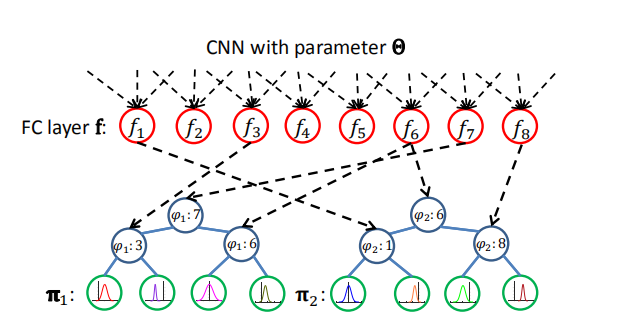

In [ ]:
def train_gmm(train_data, init_pi, init_mu, init_sigma):
  
  K = init_pi.shape[0] # 5
  N = train_data.shape[0]
  pi, mu, sigma = init_pi, init_mu, init_sigma
  gamma = np.zeros((N,K))
  scores = np.zeros((N,K))
  for iters in range(50):
    for k in range(K):
      scores[:,k] = multivariate_normal.pdf(train_data, mean=mu[k,:], cov=sigma[k,:,:])*pi[k,0]
    gamma = scores/np.sum(scores,axis=1,keepdims=True)

    pi = np.sum(gamma,axis=0)/N
    pi = pi.reshape(K,1)
    mu = np.dot(gamma.T,train_data)/np.sum(gamma,axis=0,keepdims=True).T
    for k in range(K):
      sigma[k,:,:] = np.dot((train_data-mu[k,:]).T,np.multiply(gamma[:,k].reshape(N,1),train_data-mu[k,:]))/np.sum(gamma,axis=0)[k]
  states = {'pi': pi, 'mu': mu, 'sigma': sigma,}
  return states

In [ ]:
def layer2_RF(input,weights):
  a
  return pred

In [ ]:
def loss

In [ ]:
def solver

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from sklearn.metrics import pairwise_distances  # Don't use other functions in sklearn

def train_kmeans(train_data, initial_centroids):
  ##### TODO: Implement here!! #####
  miu = initial_centroids
  for iters in range(50):
    distance = pairwise_distances(train_data,miu) # (16384,16)
    r_TF = distance == np.min(distance,axis=1,keepdims=True)
    r = r_TF+0 # (16384,16), 0-1
    count = np.sum(r,axis=0,keepdims=True).T #(16,1)
    miu = np.dot(train_data.T,r).T / count
    
  # Hint: pairwise_distances() might be useful
  states = {
      'centroids': miu
  }
  ##### TODO: Implement here!! #####
  return states

def test_kmeans(states, test_data):
  result = {}
  ##### TODO: Implement here!! #####
  #print(test_data.shape)
  base = states['centroids']
  distance = pairwise_distances(test_data,base) # (16384,16)
  r_TF = distance == np.min(distance,axis=1,keepdims=True)
  r = r_TF+0
  compressed_data = np.dot(r,base) # TODO: modify here!
  #print(compressed_data.shape)
  ##### TODO: Implement here!! #####
  result['pixel-error'] = calculate_error(test_data, compressed_data)
  return result

### DO NOT CHANGE ###
def calculate_error(data, compressed_data):
  assert data.shape == compressed_data.shape
  error = np.sqrt(np.mean(np.power(data - compressed_data, 2)))
  return error
### DO NOT CHANGE ###

# Load data
img_small = np.array(imageio.imread('q1data/mandrill-small.tiff')) # 128 x 128 x 3
img_large = np.array(imageio.imread('q1data/mandrill-large.tiff')) # 512 x 512 x 3

ndim = img_small.shape[-1]
train_data = img_small.reshape(-1, ndim).astype(float)
test_data = img_large.reshape(-1, ndim).astype(float)

# K-means
num_centroid = 16
initial_centroid_indices = [16041, 15086, 15419,  3018,  5894,  6755, 15296, 11460, 
                            10117, 11603, 11095,  6257, 16220, 10027, 11401, 13404]
initial_centroids = train_data[initial_centroid_indices, :]
states = train_kmeans(train_data, initial_centroids)
result_kmeans = test_kmeans(states, test_data)
print('Kmeans result=', result_kmeans)


from scipy.stats import multivariate_normal  # Don't use other functions in scipy

def train_gmm(train_data, init_pi, init_mu, init_sigma):
  ##### TODO: Implement here!! #####
  
  K = init_pi.shape[0] # 5
  N = train_data.shape[0]
  pi, mu, sigma = init_pi, init_mu, init_sigma
  gamma = np.zeros((N,K))
  scores = np.zeros((N,K))
  for iters in range(50):
    for k in range(K):
      scores[:,k] = multivariate_normal.pdf(train_data, mean=mu[k,:], cov=sigma[k,:,:])*pi[k,0]
    gamma = scores/np.sum(scores,axis=1,keepdims=True)

    pi = np.sum(gamma,axis=0)/N
    pi = pi.reshape(K,1)
    mu = np.dot(gamma.T,train_data)/np.sum(gamma,axis=0,keepdims=True).T
    for k in range(K):
      sigma[k,:,:] = np.dot((train_data-mu[k,:]).T,np.multiply(gamma[:,k].reshape(N,1),train_data-mu[k,:]))/np.sum(gamma,axis=0)[k]
  # Hint: multivariate_normal() might be useful
  states = {
      'pi': pi,
      'mu': mu,
      'sigma': sigma,
  }
  ##### TODO: Implement here!! #####
  return states

def test_gmm(states, test_data):
  result = {}
  ##### TODO: Implement here!! #####
  pi, mu, sigma = states['pi'], states['mu'], states['sigma']
  K = pi.shape[0] # 5
  N = test_data.shape[0]
  probs = np.zeros((N,K))
  for k in range(K):
    probs[:,k] = multivariate_normal.pdf(test_data, mean=mu[k,:], cov=sigma[k,:,:]) * pi[k]
  probs = probs/np.sum(probs,axis=1,keepdims=True)
  compressed_data = mu[np.argmax(probs,axis=1),:]
  ##### TODO: Implement here!! #####
  result['pixel-error'] = calculate_error(test_data, compressed_data)
  return result

# GMM
num_centroid = 5
init_pi = np.ones((num_centroid, 1)) / num_centroid
init_mu = initial_centroids[:num_centroid, :]
init_sigma = np.tile(np.identity(ndim), [num_centroid, 1, 1])*1000.

states = train_gmm(train_data, init_pi, init_mu, init_sigma)
result_gmm = test_gmm(states, test_data)
print('GMM result=', result_gmm)